# Demonstration 4: Decision Tree

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sisyphus.envs import DecisionTree
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Value Iteration

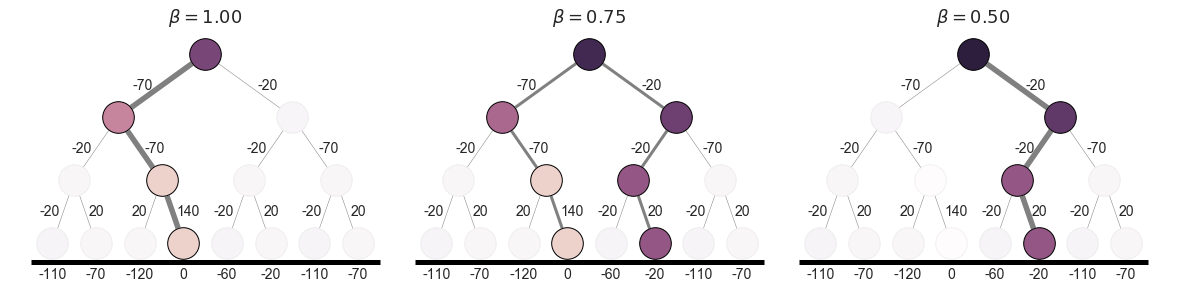

In [2]:
from sisyphus.mdp import ValueIteration
from sisyphus.mdp._misc import softmax
from sisyphus.viz import plot_decision_tree

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Simulation parameters.
betas = [1.0, 0.75, 0.5]

## Visualization parameters.
vmin, vmax = -24, 0
inv_temp = 10

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Value Iteration.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize environment.
gym = DecisionTree()

## Preallocate space.
V = np.zeros((3,gym.n_states))
theta = np.zeros((3,14))
alpha = np.zeros((3,gym.n_states))

for i, beta in enumerate(betas):
    
    ## Initialize value iteration.
    qvi = ValueIteration(policy='betamax', gamma=1.0, beta=beta)
    
    ## Solve for Q-values.
    qvi = qvi.fit(gym)
    V[i] = qvi.V.copy()
    
    ## This next section is used to calculate edge weights for
    ## visualization. Weights are a function of the likelihood
    ## of taking a certain action, as computed via the softmax.
    info = gym.info.copy()
    info["S'"] = info["S'"].apply(lambda arr: arr[0])

    ## Copy Q-values.
    info['Q'] = qvi.Q

    ## Copy likelihood of action.
    info['theta'] = info.groupby('S').Q.apply(lambda arr: softmax(arr * inv_temp))

    ## Compute joint-likelihood.
    for a in range(14):    
        info.loc[info['S'] == info.loc[a,"S'"],'theta'] *= info.loc[a,'theta']
    
    ## Store values.
    theta[i] = info.theta[:14]
    alpha[i] = info.groupby('S').theta.max()
    
## Fill in terminal states.
V[:,-8:] = [-20, 20, 20, 140, -20, 20, -20, 20]
alpha = np.where(alpha < 0.5, 0.05, 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Initialize figure.
fig = plt.figure(figsize=(16,4))
cmap = sns.cubehelix_palette(as_cmap=True, reverse=True)

## Initialize plots and divider.
gs = gridspec.GridSpec(1,3)
gs.update(left=0.0, right=1.0, bottom=0.05, top=0.9, hspace=0, wspace=0.0)

## Iteratively plot.
for i, beta in enumerate(betas):
    
    ## Initialize canvas.
    ax = plt.subplot(gs[i])
    
    ## Plot value map.
    ax = plot_decision_tree(ax, color=V[i], cmap=cmap, vmin=-60, vmax=140, alpha=alpha[i],
                            edge_width=theta[i], node_width=1, path_sums=True, edge_labels=True)
    ax.set_title(r'$\beta=%0.2f$' %beta)
    
plt.savefig('figures/04_tree.png', dpi=180)